https://betanalpha.github.io/assets/case_studies/gaussian_processes.html

In [2]:
import jax

jax.config.update("jax_enable_x64", True)

In [3]:
import numpy as np
import matplotlib.pyplot as plt

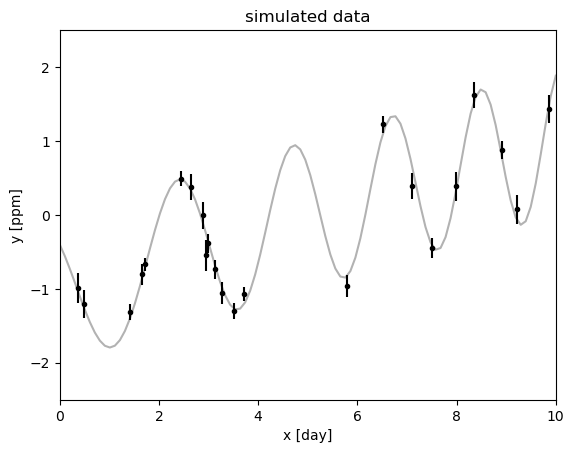

In [4]:
random = np.random.default_rng(42)

n_1, n_2 = 28, 18
n_1, n_2 = 14, 9

t = np.sort(
    np.append(
        random.uniform(0, 3.8, n_1),
        random.uniform(5.5, 10, n_2),
    )
)
yerr = random.uniform(0.08, 0.22, len(t))
y = (
    0.2 * (t - 5)
    + np.sin(3 * t + 0.1 * (t - 5) ** 2)
    + yerr * random.normal(size=len(t))
)

true_t = np.linspace(0, 10, 100)
true_y = 0.2 * (true_t - 5) + np.sin(3 * true_t + 0.1 * (true_t - 5) ** 2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [5]:
import tinygp
import jaxopt

import jax.numpy as jnp

In [6]:
def build_gp(params, x, yerr):
    mean = params["mean"]
    # log_jitter = params["log_jitter"]
    log_jitter = -10

    log_sigma1 =  params["log_sigma1"]
    log_rho1 =  params["log_rho1"]
    log_tau =  params["log_tau"]

    kernel1 = (
        jnp.exp(log_sigma1)
        * tinygp.kernels.ExpSquared(jnp.exp(log_tau))
        * tinygp.kernels.Cosine(jnp.exp(log_rho1))
    )

    log_sigma2 =  params["log_sigma2"]
    log_rho2 =  params["log_rho2"]
    kernel2 = jnp.exp(log_sigma2) * tinygp.kernels.Matern32(jnp.exp(log_rho2))

    kernel = kernel1 + kernel2
    gp = tinygp.GaussianProcess(
        kernel, x, diag=yerr**2 + jnp.exp(log_jitter), mean=mean
    )
    return gp


def neg_log_likelihood(theta, X, y, yerr):
    gp = build_gp(theta, X, yerr)
    return -gp.log_probability(y)

theta_init = {
    "mean": 0.0,
    # "log_jitter": np.log(1e-3),
    "log_sigma1": np.log(2),
    "log_rho1": np.log(2),
    "log_tau": np.log(0.5),
    "log_sigma2": np.log(2),
    "log_rho2": np.log(2),
}

gp = build_gp(theta_init, x=t, yerr=yerr)
neg_log_likelihood(theta_init, X=t, y=y, yerr=yerr)

Array(24.59517003, dtype=float64)

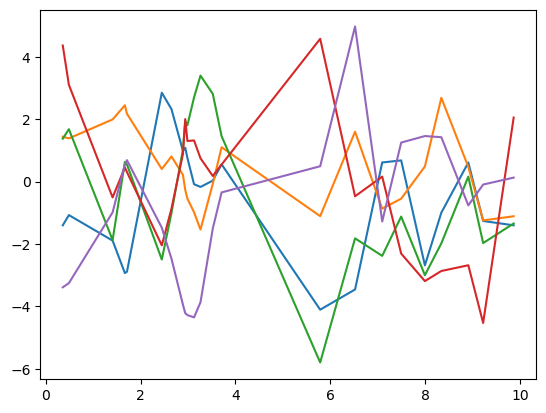

In [7]:
prior_samples = gp.sample(jax.random.PRNGKey(42), shape=(5,))
plt.plot(t, prior_samples.T)

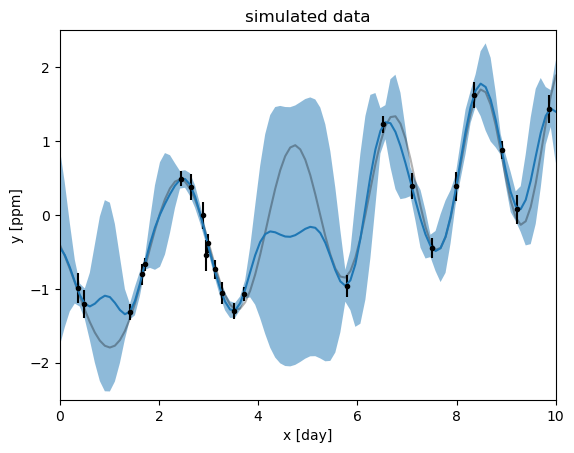

In [8]:
_, cond_gp = gp.condition(y, X_test=true_t)
mu, var = cond_gp.mean, cond_gp.variance

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

plt.plot(true_t, mu)
plt.fill_between(true_t, mu - np.sqrt(var), mu + np.sqrt(var), alpha=0.5)

plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")

In [9]:
print(f"Initial negative log likelihood: {neg_log_likelihood(theta_init, X=t, y=y, yerr=yerr)}")
solver = jaxopt.ScipyMinimize(fun=neg_log_likelihood)
soln = solver.run(theta_init, X=t, y=y, yerr=yerr)
print(f"Final negative log likelihood: {soln.state.fun_val}")
soln.params

Initial negative log likelihood: 24.59517002526264
Final negative log likelihood: 8.886931925263383


{'log_rho1': Array(0.74388354, dtype=float64),
 'log_rho2': Array(2.20376892, dtype=float64),
 'log_sigma1': Array(-0.29550676, dtype=float64),
 'log_sigma2': Array(0.6966933, dtype=float64),
 'log_tau': Array(1.32699015, dtype=float64),
 'mean': Array(0.00682507, dtype=float64)}

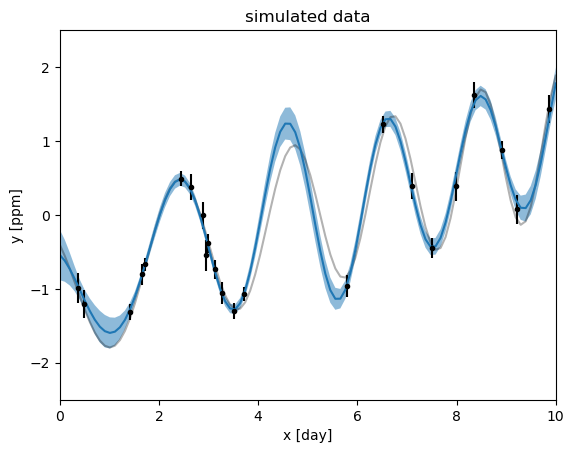

In [10]:
fit_gp = build_gp(soln.params, x=t, yerr=yerr)

cond_gp = fit_gp.condition(y, X_test=true_t).gp
mu, var = cond_gp.loc, cond_gp.variance

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)

plt.plot(true_t, mu)
plt.fill_between(true_t, mu - np.sqrt(var), mu + np.sqrt(var), alpha=0.5)

plt.xlabel("x [day]")
plt.ylabel("y [ppm]")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)
_ = plt.title("simulated data")